In [1]:
import nltk 
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords') #download stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LinearRegression

import re 

stop_words = set(stopwords.words('english'))
suffix = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagle.bagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagle.bagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
review_text_df = pd.read_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3 - Copy\\data\\reviews.csv')

In [3]:
review_text_df.dropna(inplace = True)
review_text_df = review_text_df.groupby('listing_id').filter(lambda x: x['id'].count() > 100).reset_index(drop = True)
review_text_df['comments cleaned'] = review_text_df['comments'].apply(lambda x: " ".join(x.lower() for x in x.split()))
review_text_df['comments cleaned'] = review_text_df['comments cleaned'].str.replace(r'[^\w\s]','')
review_text_df['comments cleaned'] = review_text_df['comments cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
review_text_df['comments cleaned'] = review_text_df['comments cleaned'].apply(lambda x: " ".join([suffix.stem(word) for word in x.split()]))

review_text_df['tokens'] = review_text_df.apply(lambda row: word_tokenize(row['comments cleaned']), axis = 1)

In [4]:
type(review_text_df['tokens'][1])

list

In [5]:
def sentimentFunc(x):
    return TextBlob(x).sentiment
#polarity is how positive -1 to 1, will scale to 0 to 1
#subjectivity is fact vs opinion, 0 to one, with factual being 0

In [6]:
review_text_df['senti'] = review_text_df['comments cleaned'].apply(sentimentFunc)
for index, row in review_text_df.iterrows():
    review_text_df.loc[index, 'Sentiment'], review_text_df.loc[index, 'Subjectivity'] = row['senti']


In [7]:
#review_text_df.to_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3\\data\\separated_sentiment.csv')

#review_text_df = pd.read_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3 - Copy\\data\\separated_sentiment.csv')

In [8]:
scaler = MinMaxScaler()

review_text_df['Sentiment'] = scaler.fit_transform(review_text_df[['Sentiment']])

In [9]:
listings = pd.read_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3 - Copy\\data\\listings.csv')

In [10]:
review_text_df = review_text_df.merge(listings[['review_scores_rating', 'host_name', 'id']],
                                    how = 'left', left_on = 'listing_id', right_on = 'id')

review_text_df = review_text_df.drop(columns = ['id_y','senti'])
review_text_df.rename(columns = {'id_x':'id'},inplace = True)

review_text_df['Mean Sentiment'] = review_text_df['Sentiment'].groupby(review_text_df['listing_id']).transform('mean')
review_text_df['Mean Subjectivity'] = review_text_df['Subjectivity'].groupby(review_text_df['listing_id']).transform('mean')



In [11]:
#review_text_df.to_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3\\separated_sentiment.csv')

0.03941253607188411


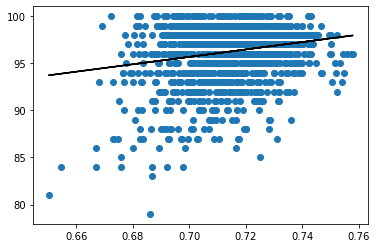

In [12]:
grouped_df = review_text_df.groupby('listing_id')

reg = LinearRegression()
X = grouped_df.mean()['Sentiment'].values[:,np.newaxis]
reg.fit(X, grouped_df.mean()['review_scores_rating'])

plt.scatter(X, grouped_df.mean()['review_scores_rating'])
plt.plot(X, reg.predict(X), color = 'black')
print(reg.score(X, grouped_df.mean()['review_scores_rating']))


In [13]:
high_subj = review_text_df.loc[review_text_df['Subjectivity'] > 0.5,:]

8.278214788137728e-05


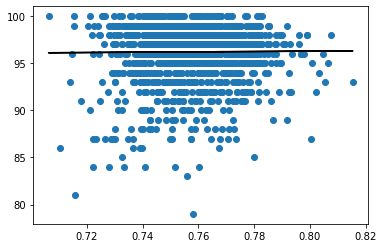

In [14]:
grouped_df = high_subj.groupby('listing_id')

reg = LinearRegression()
X = grouped_df.mean()['Sentiment'].values[:,np.newaxis]
reg.fit(X, grouped_df.mean()['review_scores_rating'])

plt.scatter(X, grouped_df.mean()['review_scores_rating'])
plt.plot(X, reg.predict(X), color = 'black')
print(reg.score(X, grouped_df.mean()['review_scores_rating']))


In [15]:
review_text_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments cleaned,tokens,Sentiment,Subjectivity,review_scores_rating,host_name,Mean Sentiment,Mean Subjectivity
0,38245,93702,2010-09-09,187475,William,"really great hist and nice place, a good locat...",realli great hist nice place good locat san di...,"[realli, great, hist, nice, place, good, locat...",0.686310,0.686607,86.0,Melinda,0.679934,0.535697
1,38245,132608,2010-11-02,269362,John,Melinda is a god person to deal with and very ...,melinda god person deal accommodatingeasi go h...,"[melinda, god, person, deal, accommodatingeasi...",0.500000,0.200000,86.0,Melinda,0.679934,0.535697
2,38245,142704,2010-11-22,108540,Suzan,Melinda's house in a beautiful part of San Die...,melinda hous beauti part san diego close airpo...,"[melinda, hous, beauti, part, san, diego, clos...",0.614286,0.295238,86.0,Melinda,0.679934,0.535697
3,38245,156426,2010-12-20,314129,Sonia,"My stay at Melinda's was great. Such a nice, w...",stay melinda great nice warm person beauti com...,"[stay, melinda, great, nice, warm, person, bea...",0.769697,0.709091,86.0,Melinda,0.679934,0.535697
4,38245,169467,2011-01-11,25218,David,Melinda is a very friendly host who is attenti...,melinda friendli host attent guest even invit ...,"[melinda, friendli, host, attent, guest, even,...",0.525000,0.250000,86.0,Melinda,0.679934,0.535697


In [17]:
#https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#

def get_listing_corpus(series_tokens):
    tokens_list = []
    for i in series_tokens:
        tokens_list = tokens_list + i
    return tokens_list

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    #sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
#     results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

In [18]:
grouped_df = review_text_df.groupby('listing_id')

tf_idf_df = pd.DataFrame(columns = ['listing_id','tokens','unique_words','tf','tfidf'], index = list(grouped_df.groups.keys()))
tf_idf_df['listing_id'] = tf_idf_df.index.values

for key, items in grouped_df:
    tokens_collected = get_listing_corpus(grouped_df.get_group(key)['tokens'])
    tf_idf_df['tokens'].loc[key] = tokens_collected
    tf_idf_df['unique_words'].loc[key] = set(tf_idf_df['tokens'].loc[key])
    
    
    cv = CountVectorizer(max_df = 0.85)
    word_count_vector = cv.fit_transform(tf_idf_df['tokens'].loc[key])
    
    tf_idf_df['tf'].loc[key] = str(cv.vocabulary_)
    
    
cv = CountVectorizer(max_df = 0.85)
word_count_vector = cv.fit_transform(get_listing_corpus(tf_idf_df['tokens']))

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
    
feature_names = cv.get_feature_names()


for index, row in tf_idf_df.iterrows():
    tf_idf_vector = tfidf_transformer.transform(cv.transform([' '.join(tf_idf_df['tokens'].loc[index])]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    
    keywords = extract_topn_from_vector(feature_names, sorted_items)
    
    tf_idf_df['tfidf'].loc[index] = str(keywords)


tf_idf_df.reset_index(inplace = True)

F:\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [28]:
tf_idf_df['tfidf'][1234]

"{'view': 0.302, 'great': 0.269, 'locat': 0.257, 'place': 0.227, 'littl': 0.168, 'unit': 0.162, 'park': 0.154, 'itali': 0.149, 'stay': 0.147, 'amaz': 0.13, 'loft': 0.126, 'get': 0.123, 'call': 0.106, 'clean': 0.102, 'would': 0.101, 'nice': 0.099, 'door': 0.098, 'time': 0.096, 'one': 0.095, 'check': 0.095, 'walk': 0.092, 'first': 0.088, 'us': 0.085, 'window': 0.083, 'airbnb': 0.082, 'back': 0.081, 'hotel': 0.079, 'beauti': 0.076, 'host': 0.075, 'got': 0.074, 'come': 0.071, 'work': 0.07, 'night': 0.068, 'recommend': 0.068, 'carlo': 0.068, 'definit': 0.066, 'respons': 0.065, 'love': 0.064, 'never': 0.064, 'realli': 0.064, 'open': 0.063, 'next': 0.063, 'dont': 0.062, 'build': 0.062, 'restaur': 0.06, 'minut': 0.06, 'instruct': 0.059, 'spot': 0.058, 'stain': 0.057, 'couch': 0.056, 'street': 0.056, 'bed': 0.055, 'right': 0.055, 'much': 0.055, 'area': 0.055, 'apart': 0.054, 'space': 0.053, 'leav': 0.052, 'arriv': 0.052, 'respond': 0.052, 'didnt': 0.051, 'need': 0.051, 'left': 0.051, 'thing': 0

talk about listing id 26782981

https://www.airbnb.com/rooms/26782981/photos/?source_impression_id=p3_1626940495_pDo2Hqmp0x%2F%2Bq0N2&guests=1&adults=1



In [20]:
tf_idf_df

,index,listing_id,tokens,unique_words,tf,tfidf
0,38245,38245,"[realli, great, hist, nice, place, good, locat...","{middl, less, nest, plumb, advic, well, shoe, ...","{'realli': 968, 'great': 551, 'hist': 595, 'ni...","{'melinda': 0.745, 'stay': 0.175, 'hous': 0.14..."
1,62274,62274,"[isabel, gener, thought, hostess, thoroughli, ...","{reinmachen, middl, straße, less, beschrieben,...","{'isabel': 1159, 'gener': 929, 'thought': 2130...","{'isabel': 0.652, 'stay': 0.197, 'place': 0.19..."
2,62949,62949,"[rental, exactli, state, lisa, provid, nice, a...","{middl, replier, honesti, less, wlot, oscar, c...","{'rental': 1337, 'exactli': 584, 'state': 1536...","{'lisa': 0.576, 'place': 0.251, 'stay': 0.241,..."
3,75668,75668,"[found, apart, clean, tidi, spaciou, wellappoi...","{univers, shelv, middl, coincident, less, deal...","{'found': 515, 'apart': 100, 'clean': 260, 'ti...","{'johnathon': 0.512, 'stay': 0.253, 'great': 0..."
4,79300,79300,"[great, stay, room, clean, nice, host, great, ...","{minut, univers, star, es, tuck, stále, middl,...","{'great': 471, 'stay': 985, 'room': 880, 'clea...","{'johnathon': 0.56, 'stay': 0.24, 'great': 0.2..."
...,...,...,...,...,...,...
1479,42143732,42143732,"[beauti, condo, downtown, sd, near, littl, ita...","{dude, minut, decor, star, woke, event, comfi,...","{'beauti': 68, 'condo': 120, 'downtown': 168, ...","{'rich': 0.491, 'place': 0.302, 'stay': 0.294,..."
1480,42608887,42608887,"[jenni, place, amaz, chic, stylish, exactli, p...","{minut, decor, sue, star, woke, middl, comfi, ...","{'jenni': 317, 'place': 448, 'amaz': 31, 'chic...","{'place': 0.346, 'beach': 0.26, 'great': 0.259..."
1481,42627855,42627855,"[great, spot, coupl, block, beach, jenni, plac...","{minut, decor, rip, supposedli, comfi, 1, less...","{'great': 285, 'spot': 599, 'coupl': 157, 'blo...","{'place': 0.316, 'beach': 0.308, 'jenni': 0.21..."
1482,42689144,42689144,"[great, spot, mission, beach, cozi, cottag, we...","{booger, star, minut, decor, middl, comfi, hea...","{'great': 240, 'spot': 479, 'mission': 335, 'b...","{'place': 0.403, 'locat': 0.342, 'beach': 0.30..."


In [21]:
#tf_idf_df.to_csv('F:\\Important Folder\\School\\UCSD Extension Data Bootcamp\\final project\\project-3 - Copy\\data\\tf_idf.csv')